In [0]:
#rm -r *

In [1]:
# Uncomment the line below and run this cell to get your data from github into colab (only runnable in colab, not ordinary jupyter notebook):
#! git clone https://github.com/lkriener/music_generation.git && mv music_generation/* . && rm music_generation -r 

Cloning into 'music_generation'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 728 (delta 19), reused 25 (delta 11), pack-reused 694
Receiving objects: 100% (728/728), 3.81 MiB | 751.00 KiB/s, done.
Resolving deltas: 100% (199/199), done.


In [2]:
# Uncomment line to install requirements
#! pip install -r colab_requirements.txt

     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 11.4MB 19.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ed/f6/fb/5d070524ecf7ba9ed201247a293c01945cfd7f840f8ef338c0
Successfully built pypianoroll
ERROR: magenta 0.3.19 has requirement mido==1.2.6, but you'll have mido 1.2.9 which is incompatible.
  Found existing installation: mido 1.2.6
    Uninstalling mido-1.2.6:
      Successfully uninstalled mido-1.2.6


# Music generation using note-to-note LSTMs 
In this part, we will try to generate melodies from the same dataset (Bach Chorals) using recurrent neural networks (RNN) with long short term memory units (LSTM) as in the tutorial 08 of the class, based on the two following blog posts:

- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://towardsdatascience.com/writing-like-shakespeare-with-machine-learning-in-pytorch-d77f851d910c

The idea would be to extend the character-to-character LSTM network to midi files. We will also use another representation of the data, namely 'pianorolls', where a single melody is stored in a matrix with the x-axis for time and the y-axis for the pitch. This is one of the most frequent representations used, although it has some limitations. For instance, there is no way to differentiate between a long note (1 half-note) and 4 short-ones (4 eight-notes). However, it brings a considerable advantage compared to the previous used representations as it can store rhythm, depending on the chosen time-step. 

Moreover, each possible note is considered as a distinct element of a vocabulary. We will then use $N$ input nodes, where $N$ is the size of the vocabulary (i.e., the number of distinct notes, including silences). 
Thus, these pianorolls arrays will be converted into one-hot vectors containing the corresponding pitch (or silence, represented by 0) for each time step, and will be fed to the RNN network defined below. 

## Test of pypianoroll library
We will first use the pypianoroll library - https://salu133445.github.io/pypianoroll/ - to convert a midi file into a multitrack object, get the soprano track, transpose it to C major, create a new multitrack object out of it, and finally write it to a new midi file. 

In [3]:

import pygame
from pypianoroll import Multitrack, Track
import pypianoroll
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from src.dataset_utils import TrackDataset, get_dataset_representation_from_tracks
from torch.utils.data import DataLoader
%pylab inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2973696/45929032 bytes (6.5%)6676480/45929032 bytes (14.5%)10428416/45929032 bytes (22.7%)14131200/45929032 bytes (30.8%)17891328/45929032 bytes (39.0%)21594112/45929032 bytes (47.0%)25305088/45929032 bytes (55.1%)28884992/45929032 bytes (62.9%)32604160/45929032 bytes (71.0%)36298752/45929032 bytes (79.0%)39837696/45929032 bytes (86.7%)

In [4]:
from src.RNN_utils import *

Training on GPU!


In [0]:
try:
    home_dir
except NameError:
    home_dir = os.getcwd()

os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir

In [6]:
# get lower and upper bounds 
voice = 0 
all_pianorolls, midi_files = get_all_pianorolls(voice, home_dir, beat_resolution=4)
global_lower, global_upper, n_notes = get_extremum_pitches([all_pianorolls])
print('Global lower note : '+ str(global_lower))
print('Global upper note : '+ str(global_upper))
print('Number of notes : '+ str(n_notes))

Global lower note : 57
Global upper note : 83
Number of notes : 28


In [7]:
print("Pianoroll sequence of soprano :")
print(all_pianorolls[0:100])

Pianoroll sequence of soprano :
[ 0  0  0  0 66 66 68 68 70 70 70 70 71 71 71 71 73 73 73  0 73 73 73 73
 75 75 75 75 77 77 77 77 78 78 78 78 66 66 68 68 70 70 70 70 71 71 71 71
 73 73 73  0 73 73 73 73 71 71 71 71 70 70 70 70 68 68 68 68 70 70 70 70
 66 66 66  0 66 66 66 66 71 71 71 71 70 70 70 70 68 68 68 68 68 68 68 68
 66 66 66  0]


In order to minimize the size of one-hot encode vectors, we restrict the pitches to values next to 0, using the minimum pitch found in the dataset. 

In [8]:
# scale pianoroll to 0 
print("Pianoroll sequence of soprano scaled to 0:")
all_pianorolls_scaled = scale_pianoroll(all_pianorolls, global_lower)
print(all_pianorolls_scaled[0:100])

Pianoroll sequence of soprano scaled to 0:
[ 0  0  0  0 10 10 12 12 14 14 14 14 15 15 15 15 17 17 17  0 17 17 17 17
 19 19 19 19 21 21 21 21 22 22 22 22 10 10 12 12 14 14 14 14 15 15 15 15
 17 17 17  0 17 17 17 17 15 15 15 15 14 14 14 14 12 12 12 12 14 14 14 14
 10 10 10  0 10 10 10 10 15 15 15 15 14 14 14 14 12 12 12 12 12 12 12 12
 10 10 10  0]


## Generation of a single voice

As a first attempt to generate a melody using LSTMs with pianorolls, we will simply try to generate a single voice (soprano, alto, tenor or bass), training the network on the whole midi file dataset concatenated into a long sequence of notes all translated to the same tonality (here, C Major or its relative A minor). The later operation will particularly facilitate learning on such a small dataset as all melodies will be rescaled to the same tonality, thus preventing abrupt changes among melody batches. 

### Define a LSTM network as for note-to-note melody generation
We now build a network to implement note-to-note melody generation using LSTMs units as well as drop-out of the output. This network is highly inspired from the Tutorial 08 of the class, by replacing characters by notes. 

For training the model, we declare a function, where we define an optimizer (Adam) and loss (cross entropy). Then, training and validation data are separated and the hidden state of the RNN is initaliazed. Looping over the training melody batches, we use the functions `get_pianoroll_batches` and `one_hot_encode_batch` in order to build batches and feed them to the network input. This function is also adapted to harmonization that will be defined below. 

Every once a while, we generate some loss statistics (training loss and validation loss) to let us know if the model is training correctly.

In [9]:
# Define and print the net
n_hidden=256
n_layers=2

net = NoteRNN(n_notes, n_hidden, n_layers)
print(net)

# Declaring the hyperparameters
batch_size = 64
seq_length = 50
n_epochs = 100 # start smaller if you are just testing initial behavior

# train the model
train_losses, val_losses, best_net, best_epoch = train(net, all_pianorolls_scaled, harmonization=False,
                                             epochs=n_epochs, batch_size=batch_size, 
                                             seq_length=seq_length, lr=0.001)

NoteRNN(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)
Epoch: 10/100... Loss: 0.9186... Val Loss: 0.9326
Epoch: 20/100... Loss: 0.5670... Val Loss: 0.6559
Epoch: 30/100... Loss: 0.4450... Val Loss: 0.6416
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 40/100... Loss: 0.3446... Val Loss: 0.6513
Epoch: 50/100... Loss: 0.2483... Val Loss: 0.7073
Epoch: 60/100... Loss: 0.1670... Val Loss: 0.7891
Epoch: 70/100... Loss: 0.1058... Val Loss: 0.8945
Epoch: 80/100... Loss: 0.0747... Val Loss: 0.9125
Epoch: 90/100... Loss: 0.0640... Val Loss: 0.9937
Epoch: 100/100... Loss: 0.0412... Val Loss: 1.0092


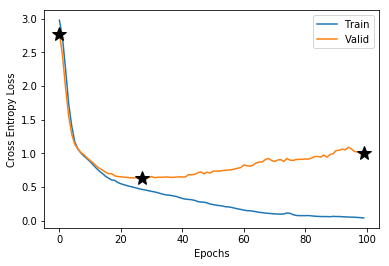

In [31]:
fig = figure(figsize(6,4))
ax = fig.add_subplot(1,1,1)
display_losses(ax, train_losses, val_losses, best_epoch)

In [0]:
fig.savefig(home_dir + "/graphics/RNN_single_plot.png")
fig.savefig(home_dir + "/graphics/RNN_single_plot.pdf")

### Test of the network: generation of single voice 
We will now test the trained network to predict potential melodies starting from a short sequence of notes. Here again, the functions `predict` and `sample` are highly inspired from the Tutorial 8, and slightly modified towards pianorolls data processing. 



The `NoteRNN` network outputs scaled pianorolls. We thus need to send back the obtained pitches to the associated voice range, using the function `unscale_pianoroll`. We then store the pianoroll to a track object, and to a multitrack object, which can directly be used to write a midi file. 

In [0]:
seq_size = 50
start = 73 - global_lower # starting with a C 

Let's first try melody generation with a random initial network (no training). 

In [0]:
random_net = NoteRNN(n_notes, n_hidden, n_layers)
multitrack_random = process_single(random_net, start, seq_size, global_lower, beat_resolution=2)
pypianoroll.write(multitrack_random, home_dir + "/results/RNN_single_random")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_single_random.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()

As expected, it does not sound like a Bach melody, as it is totally out of key. 
Let's now try it with the early-stopped network.

In [0]:
multitrack_early = process_single(best_net, start, seq_size, global_lower, beat_resolution=2)
pypianoroll.write(multitrack_early, home_dir + "/results/RNN_single_early")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_single_early.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()

Finally, we try to generate Bach melody with the overfitting network. 

In [0]:
multitrack_overfit = process_single(net, start, seq_size, global_lower, beat_resolution=2)
pypianoroll.write(multitrack_overfit, home_dir + "/results/RNN_single_overfit")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_single_overfit.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()

**********
**********

## Train for harmonization

We observed above that it is possible to generate a coherent melody using a slightly modified version of the original character-to-character RNN. Here, we will investigate whether such a network can perform more complex task, such as harmonizing a given voice. For instance, from the soprano sequence, we would like to generate the associated alto voice. 

In [0]:
beat_resolution = 2
all_pianorolls_soprano, midi_files = get_all_pianorolls(0, home_dir, beat_resolution=beat_resolution)
all_pianorolls_alto,_ = get_all_pianorolls(1, home_dir, beat_resolution=beat_resolution)
all_pianorolls_tenor,_ = get_all_pianorolls(2, home_dir, beat_resolution=beat_resolution)
all_pianorolls_bass,_ = get_all_pianorolls(3, home_dir, beat_resolution=beat_resolution)

In [8]:
list_pianorolls = [all_pianorolls_soprano, all_pianorolls_alto, all_pianorolls_tenor, all_pianorolls_bass]
global_lower, global_upper, n_notes = get_extremum_pitches(list_pianorolls)
print('Global lower note : '+ str(global_lower))
print('Global upper note : '+ str(global_upper))
print('Number of notes : '+ str(n_notes))

Global lower note : 35
Global upper note : 83
Number of notes : 50


We now rescale the pianorolls to values next to 0. 

In [0]:
# scale pianoroll to 0 
all_pianorolls_soprano = scale_pianoroll(all_pianorolls_soprano, global_lower)
all_pianorolls_alto = scale_pianoroll(all_pianorolls_alto, global_lower)
all_pianorolls_tenor = scale_pianoroll(all_pianorolls_tenor, global_lower)
all_pianorolls_bass = scale_pianoroll(all_pianorolls_bass, global_lower)


It is now time to train the network to perform harmonization. Setting the mode to `"harmonization"`, we will call the function `get_pianoroll_batches_harmonization` that generates one-hot vectors of both input and target melodies. 

In [0]:
# Define and print the net
n_hidden=512
n_layers=2

net_alto = NoteRNN(n_notes, n_hidden, n_layers)
net_tenor = NoteRNN(n_notes, n_hidden, n_layers)
net_bass = NoteRNN(n_notes, n_hidden, n_layers)

# Declaring the hyperparameters
batch_size = 64
seq_length = 32
n_epochs = 100 # start smaller if you are just testing initial behavior

In [29]:
# train the model
train_losses_alto, val_losses_alto, best_net_alto, best_epoch_alto = train(net_alto, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_alto, harmonization=True,
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.005)



Epoch: 10/100... Loss: 1.7724... Val Loss: 1.9143
Epoch: 20/100... Loss: 1.4594... Val Loss: 1.8830
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 30/100... Loss: 0.9607... Val Loss: 2.1585
Epoch: 40/100... Loss: 0.5118... Val Loss: 2.6725
Epoch: 50/100... Loss: 0.2912... Val Loss: 3.3700
Epoch: 60/100... Loss: 0.1413... Val Loss: 3.5645
Epoch: 70/100... Loss: 0.4071... Val Loss: 3.2366
Epoch: 80/100... Loss: 0.1099... Val Loss: 3.7456
Epoch: 90/100... Loss: 0.1308... Val Loss: 3.8599
Epoch: 100/100... Loss: 0.0713... Val Loss: 4.1972


In [30]:
# train the model
train_losses_tenor, val_losses_tenor, best_net_tenor, best_epoch_tenor = train(net_tenor, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_tenor, harmonization=True,
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.005)

Epoch: 10/100... Loss: 1.9025... Val Loss: 1.9449
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 20/100... Loss: 1.5353... Val Loss: 1.9442
Epoch: 30/100... Loss: 0.9592... Val Loss: 2.2786
Epoch: 40/100... Loss: 0.4850... Val Loss: 2.9810
Epoch: 50/100... Loss: 0.3112... Val Loss: 3.3585
Epoch: 60/100... Loss: 0.1225... Val Loss: 3.7991
Epoch: 70/100... Loss: 0.1257... Val Loss: 4.0353
Epoch: 80/100... Loss: 0.1345... Val Loss: 4.0276
Epoch: 90/100... Loss: 0.0629... Val Loss: 4.4625
Epoch: 100/100... Loss: 0.0196... Val Loss: 4.6923


In [31]:
# train the model
train_losses_bass, val_losses_bass, best_net_bass, best_epoch_bass = train(net_bass, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_bass, harmonization=True,
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.005)

Epoch: 10/100... Loss: 1.9182... Val Loss: 2.1263
No improvement for 5 epochs; storing val_loss and best_model...
Epoch: 20/100... Loss: 1.1994... Val Loss: 2.3309
Epoch: 30/100... Loss: 0.4809... Val Loss: 2.9537
Epoch: 40/100... Loss: 0.1855... Val Loss: 3.4340
Epoch: 50/100... Loss: 0.0497... Val Loss: 3.9113
Epoch: 60/100... Loss: 0.0509... Val Loss: 4.0649
Epoch: 70/100... Loss: 0.3472... Val Loss: 3.6581
Epoch: 80/100... Loss: 0.0508... Val Loss: 4.0438
Epoch: 90/100... Loss: 0.0170... Val Loss: 4.3854
Epoch: 100/100... Loss: 0.0098... Val Loss: 4.5786


### Losses evolution with training and overfitting 
Now that our 3 networks are trained, we will inspect how the losses evolve with harmonization for each of the generated voices. 

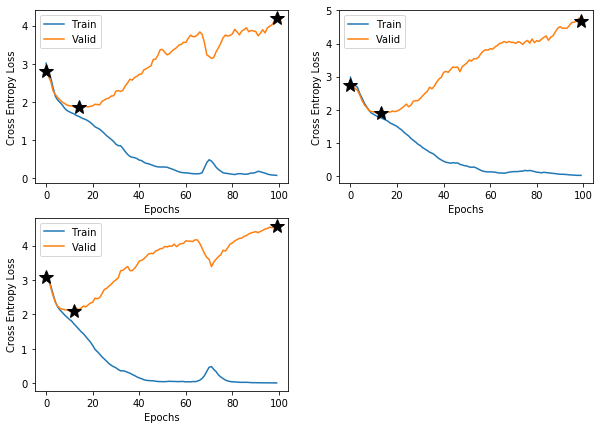

In [32]:
fig = figure(figsize(10,7))
ax1 = fig.add_subplot(2,2,1)
display_losses(ax1, train_losses_alto, val_losses_alto, best_epoch_alto)
ax2 = fig.add_subplot(2,2,2)
display_losses(ax2, train_losses_tenor, val_losses_tenor, best_epoch_tenor)
ax3 = fig.add_subplot(2,2,3)
display_losses(ax3, train_losses_bass, val_losses_bass, best_epoch_bass)

In [0]:
fig.savefig(home_dir + "/graphics/RNN_harmonization_plot.png")
fig.savefig(home_dir + "/graphics/RNN_harmonization_plot.pdf")

### Test of harmonization from a soprano track

It is now time to test the quality of the RNNs trained to harmonize a soprano voice by generating separately alto, tenor and bass voices. We will test it on one given bach midi file in the browser. 

In [38]:
 # Generating harmonization
os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir
# get one voice from the dataset 
#midi_filename = 'bwv368.mid'
midi_filename = midi_files[-4]
print("Let's generate alto, tenor and bass from "+ midi_filename + " soprano")
#midi_filename = 'pkgsc_azalea.mid'

start_size = 8

real_tracks = []
for voice in range(4):
    track = get_track(midi_filename, voice, beat_resolution=beat_resolution, transpose=True)
    real_tracks.append(track)

Let's generate alto, tenor and bass from bwv374.mid soprano


Let's first generate harmonization with a ramdom initial network, without training. 

In [0]:
random_net_alto = NoteRNN(n_notes, n_hidden, n_layers)
random_net_tenor = NoteRNN(n_notes, n_hidden, n_layers)
random_net_bass = NoteRNN(n_notes, n_hidden, n_layers)

random_networks = [None, random_net_alto, random_net_tenor, random_net_bass]
generated_tracks_random = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = process_harmonization(midi_filename, random_networks, 
                                            global_lower, real_tracks, voice_togenerate, start_size)
    generated_tracks_random.append(generated_track)
    
multitrack_random = Multitrack(tracks=generated_tracks_random, 
                            tempo = 90, beat_resolution=beat_resolution)
#write to midifile 
pypianoroll.write(multitrack_random, home_dir + "/results/RNN_harmonization_random")

In [47]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_random.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

error: ignored

In [48]:
pygame.mixer.music.stop()

error: ignored

As expected, the harmonization is totally random, thus all voices are not following the soprano melody and generate random melodies independently. d
Let's now test the quality of harmonization for the non-overfitting early-stopped networks.  

In [0]:
best_networks = [None, best_net_alto, best_net_tenor, best_net_bass]

# Early stopped network test 
generated_tracks_early = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = process_harmonization(midi_filename, best_networks, 
                                            global_lower, real_tracks, voice_togenerate, start_size)
    generated_tracks_early.append(generated_track)
    
multitrack_early = Multitrack(tracks=generated_tracks_early, 
                            tempo = 90, beat_resolution=beat_resolution)
#write to midifile 
pypianoroll.write(multitrack_early, home_dir + "/results/RNN_harmonization_early")

In [50]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_early.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

error: ignored

In [51]:
pygame.mixer.music.stop()

error: ignored

The obtained track sounds much better and start to harmonize the soprano voice correctly, especially by trying to match the soprano rhythm. However, it is not optimal as we cannot hear any coherent harmonies and cadences. 
Let's finally try on the highly-overfitting network. 

In [0]:
networks = [None, net_alto, net_tenor, net_bass]

# Overfitting network test 
generated_tracks_overfit = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = process_harmonization(midi_filename, networks, 
                                            global_lower, real_tracks, voice_togenerate, start_size)
    generated_tracks_overfit.append(generated_track)
multitrack_overfit = Multitrack(tracks=generated_tracks_overfit, 
                            tempo = 90, beat_resolution=beat_resolution)
#write to midifile 
pypianoroll.write(multitrack_overfit, home_dir + "/results/RNN_harmonization_overfit")    

In [53]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_overfit.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

error: ignored

In [54]:
pygame.mixer.music.stop()

error: ignored

The overfitting networks sounds to generate voices that match much better with the soprano voice than the previous networks! Even if at the beginning, the voices are not really coherent, they start to catch some relevant melodies that vertically harmonize the soprano voice. 
We hypothesize that such surprising results might be specific to music generation. Bach Chorales are quite similar, especially when transcripted to C Major (or its relative A minor), and overfitting the training set can lead to optimal network features to generate 3 voices on a soprano voice which harmonization was never learned (validation set). Even if the validation error is huge compared to the early stopping case, it does not mean that the generated voices are wrong. The overfitted network generate complete different alto/tenor/bass melodies from the original ones, which might explain this huge validation error, but these melodies vertically compose different chords and cadences that can turn out to be really coherent! 
As an example, think of the original track ending up with an interrupted cadence, in a total different tonality than C Major (let's say, A Major), which has been seen less often that a perfect cadence (C Major) in the training set. The overfitting network will unless try to recover this perfect cadence as it learned to do by overfitting, and thus generate complete different melodies than the target ones, but vertically coherent with each other to produce such a perfect cadence! 

As an illustration of such a phenomenon, let's listen to original track (real alto/tenor/bass voices) and compare to the overfitted track at the same time steps. 

In [0]:
# Real track 
multitrack_real = Multitrack(tracks=real_tracks, tempo = 90, beat_resolution=beat_resolution)
# write to midifile 
pypianoroll.write(multitrack_real, home_dir + "/results/RNN_harmonization_real")

In [0]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_real.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [0]:
pygame.mixer.music.stop()